# Probabilistic classification

Binary classification tasks allow just two possible outcomes per prediction. That result often obscures additional context that is available from the classifier.

For example, $k$ nearest neighbors reports the winner of the majority of votes among the $k$ examples closest to the query point. But we should probably be more skeptical about a query that wins, say, by a 4--3 vote as opposed to 7--0. To give a more nuanced picture, we could report the fraction of votes cast for the positive label. Then there are $k+1$ possible values equally spaced between 0 and 1. In the case of a decision tree, each query eventually ends up at a leaf of sample points, and we can report the fraction of samples that have the positive label.

It's easy to interpret such a result as predicting the *probability* of the positive label at any query point. Conceptually this is more akin to regression than classification, because learner outputs values between 0 and 1, even though the data are all presented with labels from the set $\{0,1\}$. 

Consider the penguin species classification problem.

In [1]:
import seaborn as sns
penguins = sns.load_dataset("penguins").dropna()
# Select only numeric columns for features:
X = penguins.loc[:,penguins.dtypes=="float64"]  
y = penguins["species"].astype("category")

from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=5)

We can use $k=5$ on a nearest neighbors classifier, and use it to predict species as we have before.

In [2]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr,y_tr)
knn.predict(X_te.iloc[:6,:])

array(['Adelie', 'Adelie', 'Gentoo', 'Gentoo', 'Adelie', 'Adelie'],
      dtype=object)

But we can also access the probabilistic interpretation via `predict_proba`.

In [3]:
phat = knn.predict_proba(X_te)
phat[:6,:]

array([[0.8, 0.2, 0. ],
       [0.8, 0.2, 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0.8, 0.2, 0. ],
       [0.6, 0.4, 0. ]])

From the output above we see that, for example, while the third and fourth test cases led to unanimous votes for *Gentoo*, the sixth case was deemed *Adelie* in a 3--2 squeaker (or is it squawker?).

## ROC curve

The **ROC curve**, or *receiver operator characteristic* curve, is a way to play what-if by adjusting the voting margins needed to "win" a positive label. Let's explain by continuing the penguin example.

In [4]:
from sklearn.metrics import roc_curve
import pandas as pd

# Function to get the ROC curve data, given true labels and an array of probabilistic
# predictions. Returns one frame of curve data per unique label.
def get_roc_data(y,p_hat,labels):
    out = []
    # Each species gets a turn at being the "positive" outcome (one vs rest)
    for (i,label) in enumerate(labels):  
        fp,tp,theta = roc_curve(y,p_hat[:,i],pos_label=label)  
        out.append(pd.DataFrame({"FP rate":fp,"TP rate":tp,"threshold":theta}))
    return out

p_hat = knn.predict_proba(X_te)
# Use the classes_ property of the regressor to ensure that we use the same ordering of 
# the labels as in the columns of p_hat.
labels = knn.classes_
roc = get_roc_data(y_te,p_hat,labels)
roc[0]

,FP rate,TP rate,threshold
0,0.000000,0.000000,2.0
1,0.027027,0.233333,1.0
2,0.054054,0.566667,0.8
3,0.216216,0.900000,0.6
4,0.405405,0.966667,0.4
5,0.459459,1.000000,0.2
6,1.000000,1.000000,0.0


The output above details what happens to the recall (aka *TP rate*) and 1 minus the specificity (the *FP rate*) as the threshold for choosing *Adelie* starts from never, then requiring 100% of the votes, then 80% of the votes, and so on, ending up with always choosing *Adelie*. Here is how the results appear graphically for all three species:

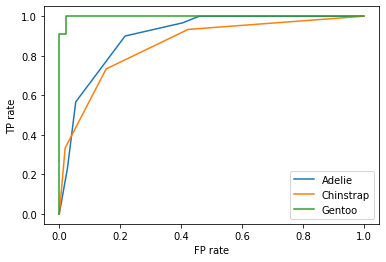

In [5]:
import matplotlib.pyplot as plt
for df in roc:
    plt.plot(df["FP rate"],df["TP rate"])
plt.xlabel("FP rate")
plt.ylabel("TP rate")
plt.legend(labels);

The ideal situation is in the top left corner of the plot, corresponding to perfect recall and specificity. Each curve starts in the lower left corner and ends at the upper right corner. The *Gentoo* curve comes quite close to the ideal. All of the curves explicitly show the tradeoff between recall and specificity. The information could be used to choose a threshold that favors either side of the tradeoff.

If we weight neighbors' votes inversely to their distance from the query point, then the thresholds aren't restricted to multiples of $\tfrac{1}{5}$.

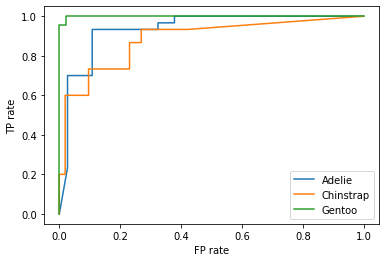

In [6]:
knnw = KNeighborsClassifier(n_neighbors=5,weights="distance")
knnw.fit(X_tr,y_tr)
roc = get_roc_data(y_te,knnw.predict_proba(X_te),labels)
for df in roc:
    plt.plot(df["FP rate"],df["TP rate"])
plt.xlabel("FP rate")
plt.ylabel("TP rate")
plt.legend(labels);

ROC curves lead to another classification performance metric known as **area under ROC curve** (AUC-ROC). Its name tells you exactly what it is, and it ranges between zero (bad) and one (ideal). Unlike the other classification metrics we have encountered, AUC-ROC tries to account not just for the final result of the classification, which nominally occurs when the threshold is $\tfrac{1}{2}, but also for the confidence with which those results can be predicted.

The function `roc_auc_score` requires a keyword argument when there are more than two classes, to specify "one vs. rest" or "one vs. one" matchups.

In [7]:
from sklearn.metrics import roc_auc_score
p_hat = knn.predict_proba(X_te)
s = roc_auc_score(y_te,p_hat,multi_class="ovr")
print("AUC for knn-uniform:",s)

s = roc_auc_score(y_te,knnw.predict_proba(X_te),multi_class="ovr")
print("AUC for knn-weights:",s)

AUC for knn-uniform: 0.9193947443947442
AUC for knn-weights: 0.9393029393029394
